# Лабораторная работа №4

In [76]:
import matplotlib.pyplot as plt
import numpy as np

from numpy.fft import fft, ifft, fftfreq
from typing import Union

In [77]:
def cyclic_freq(T: float):
    return 2 * np.pi / T

In [78]:
def period(f: float):
    return 1 / f

In [79]:
def apply_fft(func, dt: float, y: np.ndarray):

    xfft = fftfreq(y.size) / dt
    yfft = func(y)

    return xfft, yfft

In [80]:
def plot_signal(**kwards):
    
    # Точки временного пространства
    x  = kwards.get('x')
    y0 = kwards.get('y0')
    y1 = kwards.get('y1')
    
    # Точки частотного пространства
    xf  = kwards.get('xf')
    yf0 = kwards.get('yf0')
    yf1 = kwards.get('yf1')

    # Ограничение оси абсцисс
    t = kwards.get('t')
    f = kwards.get('f')

    # Легенды графиков
    legendy0  = kwards.get('legend_y0')
    legendy1  = kwards.get('legend_y1')
    legendyf0 = kwards.get('legend_yf0')
    legendyf1 = kwards.get('legend_yf1')

    fig = plt.figure()

    if y0 is not None:    
        ax = fig.add_subplot(211)

        ids = range(len(xf))

        if t is not None:   
            ids = np.logical_and(x >= t[0], x <= t[1])

        ax.plot(x[ids], y0[ids], 'b', label = legendy0)

        if y1 is not None:
            ax.plot(x[ids], y1[ids], '--', color = 'y', label = legendy1) 

        ax.set_ylabel('Амплитуда')
        ax.set_xlabel('Время, с')

        if any([legendy0, legendy1]):
            ax.legend(loc = 'upper right')

    if yf0 is not None:
        ax = fig.add_subplot(212)

        ids = range(len(xf))

        if f is not None: 
            ids = np.logical_and(xf >= f[0], xf <= f[1])

        ax.bar(xf[ids], np.abs(yf0[ids]) / len(yf0), label = legendyf0)

        if yf1 is not None:
            ax.plot(xf[ids], np.abs(yf1[ids] / len(yf1)), '--', color = 'y', label = legendyf1)

        ax.set_ylabel('Амплитуда')
        ax.set_xlabel('Частота, Гц')

        if any([legendyf0, legendyf1]):
            ax.legend(loc = 'upper right')

    fig.set_figwidth(8)
    fig.set_figheight(2 * len(fig.axes))

    fig.tight_layout()
    plt.show()

In [81]:
def func_x(func, A: float, T: Union[float, list, tuple], interval: tuple, sample_rate: int = 1000):

    x, step = np.linspace(interval[0], 
                          interval[1], 
                          num = sample_rate, 
                          endpoint = False, 
                          retstep = True)

    if isinstance(T, float):
        y = np.apply_along_axis(lambda z: func(z, A, cyclic_freq(T)), 0, x)
    else:
        y = np.sum([
            np.apply_along_axis(lambda z: func(z, A, cyclic_freq(T[t])), 0, x)
            for t in range(len(T))],
            axis = 0)
    
    return x, y, step

In [82]:
def cos_func(x: float, A: float, w: float):
    return A * np.cos(w * x)

## Задание 1

In [83]:
SAMPLE_RATE = 5000
interval  = (0, 1)
A  = 1
f1 = 50
f2 = 150
f3 = 450

In [84]:
x, y, step = func_x(cos_func, A, [period(f1), period(f2), period(f3)] , interval, SAMPLE_RATE)
xfft, yfft = apply_fft(fft, step, y)

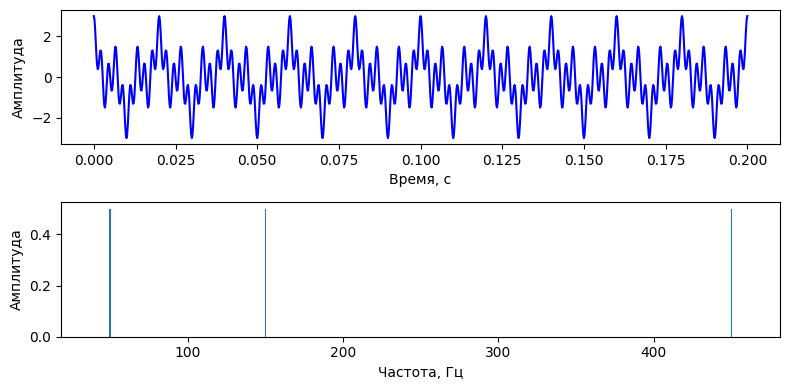

In [85]:
plot_signal(x = x, y0 = y, xf = xfft, yf0 = yfft, t = (0, 0.2), f = (40, 460))

## Задание 2

In [86]:
class Butterworth_filter:

    def __init__(self, signal: np.ndarray, step: float):
        self.yfft = apply_fft(fft, step, signal)[1]

    def __H_w(self, w, wc: float, mode: str = 'LPF', order = 2):

        if mode == 'LPF':
            omega = w / wc

        elif mode == 'HPF':
            omega = wc / w

        return 1 / (1 + (1j * omega) ** (2 * order)) 

    def LPF(self, wc: float):  
        
        filtered_yfft = np.zeros_like(self.yfft)

        for i in range(len(filtered_yfft)):
            filtered_yfft[i] = self.__H_w(self.yfft[i], wc, 'LPF') * self.yfft[i]

        # filtered_yfft = np.apply_along_axis(
        #     lambda w: self.__H_w(w, wc, 'LPF') * w, 0, self.yfft)
        
        return ifft(filtered_yfft).real

In [87]:
butterworth = Butterworth_filter(y, step)

y = butterworth.LPF(wc = 502) 
xfft, yfft = apply_fft(fft, step, y)

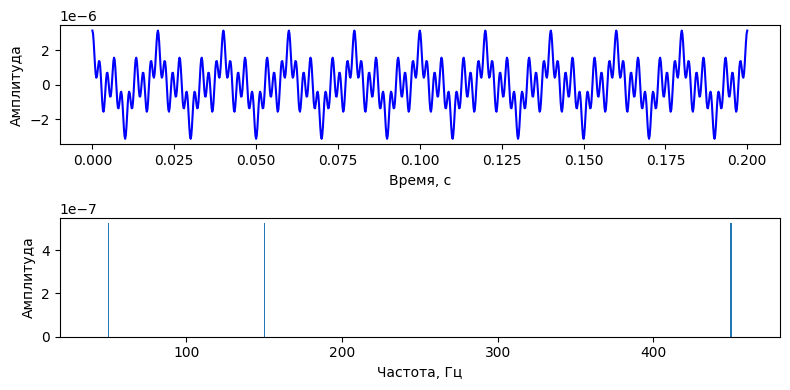

In [88]:
plot_signal(x = x, y0 = y, xf = xfft, yf0 = yfft, t = (0, 0.2), f = (40, 460))